In [1]:
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv('selected_data.csv')
data['GDatetime'] = pd.to_datetime(data['GDatetime'])
data.set_index('GDatetime', inplace=True)
data

,F_RunState,F_CycleTime,F_SpindleRPM1,F_SpindleTroq1,F_SpindleGearRatio1,F_ToolNum,G_ADC1,G_ADC2,G_ADC3,G_MV,G_MA,G_MActP,G_MFeq,G_MTemp,label,anomaly
GDatetime,,,,,,,,,,,,,,,,
2023-06-05 07:03:45,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,222.020004,2.974,0.924,59.970001,39.0,0,0
2023-06-05 07:03:46,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,221.529999,2.976,0.924,59.970001,39.0,0,0
2023-06-05 07:03:47,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,221.529999,2.976,0.924,59.970001,39.0,0,0
2023-06-05 07:03:48,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,220.729996,2.976,0.920,59.959999,39.0,0,0
2023-06-05 07:03:49,2.0,0.0,0.0,0.0,0.0,0.0,24.299999,43.700001,0.0,221.630005,2.962,0.920,59.959999,39.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01 16:27:16,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.570007,11.092,2.656,59.970001,45.0,363,0
2023-07-01 16:27:17,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.669998,11.046,2.644,59.970001,45.0,363,0
2023-07-01 16:27:18,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.669998,11.046,2.644,59.970001,45.0,363,0


In [3]:
def find_cycle_periods(data, threshold_low=100, threshold_high=10000, sub_cycle_threshold=1000, sub_cycle_length_minutes=50):
    cycle_starts = []
    cycle_ends = []
    in_cycle = False
    in_high = False
    in_sub_cycle = False
    label = -1 # 주기 라벨 (0부터 시작)
    
    # label 열을 추가하고 -1로 초기화
    data['label'] = 0
    sub_cycle_start_time = None
    sub_cycle_length = 0
    
    for i in range(len(data) - 1):
        value = data['F_CycleTime'].iloc[i]
        next_value = data['F_CycleTime'].iloc[i + 1]
        
        # 주기 시작 지점 찾기 (0 ~ 100 근처에서 올라가기 시작)
        if not in_cycle and value <= threshold_low:
            in_cycle = True
            label += 1 # 새로운 주기 시작, 라벨 증가
            cycle_starts.append(data.index[i]) # datetime 인덱스 사용
        
        # 주기 내부라면 현재 라벨로 표시
        if in_cycle:
            data['label'].iloc[i] = label

        # 1만 근처의 값에 도달
        if in_cycle and not in_high and value >= threshold_high:
            in_high = True

        # 1천 근처의 값에 도달
        if in_cycle and not in_high and value >= sub_cycle_threshold:
            in_sub_cycle = True
            if sub_cycle_start_time is None:
                sub_cycle_start_time = data.index[i]

        # 하위 주기의 끝 지점 찾기
        if in_sub_cycle and next_value <= threshold_low:
            sub_cycle_length += (data.index[i] - sub_cycle_start_time).seconds / 60
            sub_cycle_start_time = None
            if sub_cycle_length >= sub_cycle_length_minutes:
                in_high = True
            in_sub_cycle = False
            
        # 주기 끝 지점 찾기
        if in_high and next_value <= threshold_low:
            in_high = False
            in_cycle = False
            cycle_ends.append(data.index[i]) # datetime 인덱스 사용
            sub_cycle_length = 0
            
    # 마지막 주기의 끝 지점 처리
    if in_cycle:
        cycle_ends.append(data.index[-1])

    return cycle_starts, cycle_ends


def remove_constant_values(data, lower_bound=1000, upper_bound=12000, duration_minutes=20):
    constant_value = None
    constant_start_time = None
    rows_to_drop = []

    for i in range(len(data) - 1):
        value = data['F_CycleTime'].iloc[i]

        # 값이 범위 내에 있고 이전 값과 동일한 경우
        if lower_bound <= value < upper_bound and value == constant_value:
            if constant_start_time is None:
                constant_start_time = data.index[i]
            # 지속 시간이 20분 이상인 경우
            if (data.index[i] - constant_start_time).seconds / 60 >= duration_minutes:
                rows_to_drop.append(data.index[i])
        else:
            constant_value = value
            constant_start_time = None

    # 행 삭제
    data.drop(rows_to_drop, inplace=True)
    return data



selected_data = data

selected_data = remove_constant_values(selected_data)

# 중복된 인덱스를 가진 행의 평균값으로 병합
selected_data = selected_data.groupby(selected_data.index).mean()

cycle_starts, cycle_ends = find_cycle_periods(selected_data)

selected_data = selected_data.iloc[:-1]
selected_data['anomaly'] = 0
specific_labels = [43, 188, 243, 256, 258, 270, 291, 295, 325, 340, 349, 360]
selected_data.loc[selected_data['label'].isin(specific_labels), 'anomaly'] = 1

In [391]:
selected_data.loc['2023-06-05 07:03:45':'2023-06-05 08:03:45'][['F_RunState','F_CycleTime','F_SpindleRPM1']].values

array([[2.000e+00, 0.000e+00, 0.000e+00],
       [2.000e+00, 0.000e+00, 0.000e+00],
       [2.000e+00, 0.000e+00, 0.000e+00],
       ...,
       [1.000e+00, 2.612e+03, 4.987e+03],
       [1.000e+00, 2.613e+03, 4.987e+03],
       [1.000e+00, 2.614e+03, 4.987e+03]])

In [525]:
# 특징 선별
selected_k = selected_data.drop(['F_RunState','F_ToolNum', 'G_ADC1', 'G_ADC2',  'G_MFeq', 'G_MTemp'], axis=1)
#'G_MV', 'G_MA', 'G_MActP',

In [526]:
# 통계 데이터 생성 및 결합
tmp1 = selected_k.groupby('label').mean()
tmp2 = selected_k.groupby('label').std().drop('anomaly', axis=1)
tmp3 = selected_k.groupby('label').skew().drop('anomaly', axis=1)

tmp1 = tmp1.add_suffix('_mean')
tmp2 = tmp2.add_suffix('_std')
tmp3 = tmp3.add_suffix('_skew')

# 데이터프레임 연결
tmp = pd.concat([tmp1, tmp2, tmp3], axis=1)

In [528]:
kktr = [0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 257, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278,
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 292,
       293, 294, 296,43, 188, 243, 256, 258, 270, 291, 295]
kkte = [297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 341, 342, 343, 344, 345, 346, 347,
       348, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 361, 362,
       363, 325, 340, 349, 360]


k_X_train = tmp[tmp.index.isin(kktr)].drop('anomaly_mean', axis=1)
k_y_train = tmp[tmp.index.isin(kktr)]['anomaly_mean']
k_X_test = tmp[tmp.index.isin(kkte)].drop('anomaly_mean', axis=1)
k_y_test = tmp[tmp.index.isin(kkte)]['anomaly_mean']

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

std = StandardScaler()
mm = MinMaxScaler()

k_X_train = pd.concat([pd.DataFrame(mm.fit_transform(k_X_train.iloc[:, :2])), pd.DataFrame(std.fit_transform(k_X_train.iloc[:, 2:]))], axis=1)
k_X_test = pd.concat([pd.DataFrame(mm.fit_transform(k_X_test.iloc[:, :2])), pd.DataFrame(std.fit_transform(k_X_test.iloc[:, 2:]))], axis=1)

NameError: name 'mm' is not defined

In [522]:
# 라벨 Drop
tmp_sne = tmp.drop('anomaly_mean', axis=1)

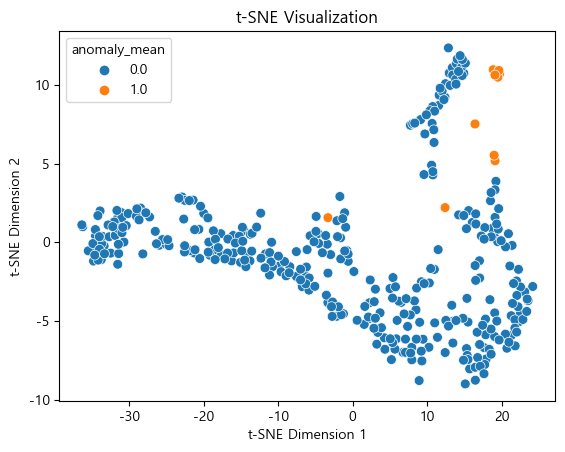

In [585]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE를 위한 객체 생성
tsne = TSNE(n_components=2, random_state=42)

# t-SNE를 통해 데이터를 2D 공간으로 변환
data_tsne = tsne.fit_transform(tmp_sne)  # data는 변환할 데이터입니다.
train_tsne = tsne.fit_transform(k_X_train)
test_tsne = tsne.fit_transform(k_X_test)

# 변환된 데이터를 시각화
sns.scatterplot(data=data_tsne, x=data_tsne[:, 0],y=data_tsne[:, 1],hue=tmp['anomaly_mean'], legend='brief', s=50, linewidth=0.5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()

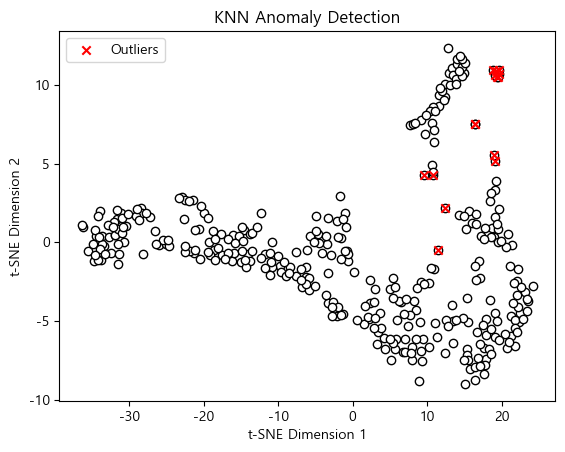

In [586]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 데이터 준비 (data_tsne 변수는 이전 t-SNE 결과를 활용)
data = data_tsne  # t-SNE로 변환된 데이터 사용

# KNN 모델 생성
k = 25  # 이웃의 수 설정
knn = NearestNeighbors(n_neighbors=k)
knn.fit(data)

# 각 데이터 포인트의 이웃 거리 가져오기
distances, _ = knn.kneighbors()

# 이상치 스코어 계산 (평균 이웃 거리 활용)
outlier_scores = np.mean(distances, axis=1)

# 이상치 여부 판단 (상위 n%만 이상치로 간주)
n_percentile = 96  # 상위 n% 이상치로 간주
threshold = np.percentile(outlier_scores, n_percentile)

# 이상치 인덱스 가져오기
outliers_indices = np.where(outlier_scores > threshold)[0]

# 이상치 시각화
plt.scatter(data[:, 0], data[:, 1], c='white', edgecolors='k')
plt.scatter(data[outliers_indices, 0], data[outliers_indices, 1], c='red', edgecolors='k', marker='x', label='Outliers')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('KNN Anomaly Detection')
plt.legend()
plt.show()

In [587]:
outliers_indices

array([  0,  27,  48, 188, 212, 243, 256, 258, 270, 291, 295, 325, 340,
       349, 360], dtype=int64)

In [588]:
boolean_values = outlier_scores > threshold

In [589]:
int_values = [int(value) for value in boolean_values]
int_values

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,


In [590]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# 혼동 행렬 계산 및 출력
confusion = confusion_matrix(tmp['anomaly_mean'], int_values)
print("Confusion Matrix:")
print(confusion)

# 분류 보고서 출력
report = classification_report(tmp['anomaly_mean'], int_values)
print("Classification Report:")
print(report)

Confusion Matrix:
[[348   4]
 [  1  11]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       352
         1.0       0.73      0.92      0.81        12

    accuracy                           0.99       364
   macro avg       0.87      0.95      0.90       364
weighted avg       0.99      0.99      0.99       364



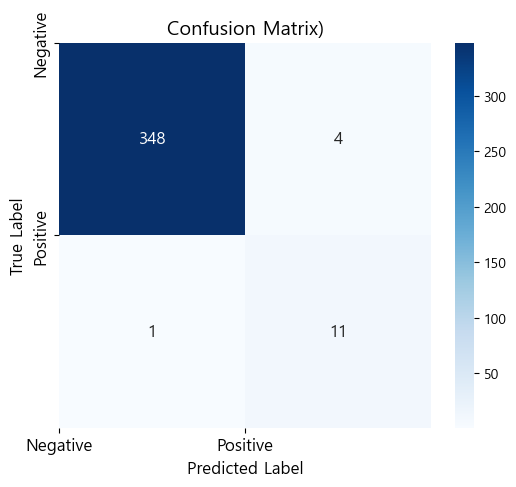

In [591]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


# 컨퓨전 매트릭스 생성
conf_matrix = confusion_matrix(tmp['anomaly_mean'],int_values)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})

plt.title(f"Confusion Matrix)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], fontsize=12)
plt.yticks(ticks=[0, 1], labels=["Negative", "Positive"], fontsize=12)
plt.show()

## I-forest

In [535]:
print(tmp[tmp['anomaly_mean']==1].index)
tmp[tmp['anomaly_mean']==0].index

Index([43, 188, 243, 256, 258, 270, 291, 295, 325, 340, 349, 360], dtype='int64', name='label')


Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       353, 354, 355, 356, 357, 358, 359, 361, 362, 363],
      dtype='int64', name='label', length=352)

In [536]:
np.array(tmp[tmp['anomaly_mean']==0].index)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [537]:
i_tr = [0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 257, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278,
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 292,
       293, 294, 296, 297, 298, 299, 300]
i_te = [301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 341, 342, 343, 344, 345, 346, 347,
       348, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 361, 362,
       363]
i_outliers = [43, 188, 243, 256, 258, 270, 291, 295, 325, 340, 349, 360]

i_concat = [301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 341, 342, 343, 344, 345, 346, 347,
       348, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 361, 362,
       363, 43, 188, 243, 256, 258, 270, 291, 295, 325, 340, 349, 360]
i_X_train = tmp[tmp.index.isin(i_tr)].drop('anomaly_mean', axis=1)
i_y_train = tmp[tmp.index.isin(i_tr)]['anomaly_mean']
i_X_test = tmp[tmp.index.isin(i_te)].drop('anomaly_mean', axis=1)
i_y_test = tmp[tmp.index.isin(i_te)]['anomaly_mean']
i_X_outliers = tmp[tmp.index.isin(i_outliers)].drop('anomaly_mean', axis=1)
i_y_outliers = tmp[tmp.index.isin(i_outliers)]['anomaly_mean']


i_X_concat = tmp[tmp.index.isin(i_concat)].drop('anomaly_mean', axis=1)
i_y_concat = tmp[tmp.index.isin(i_concat)]['anomaly_mean']

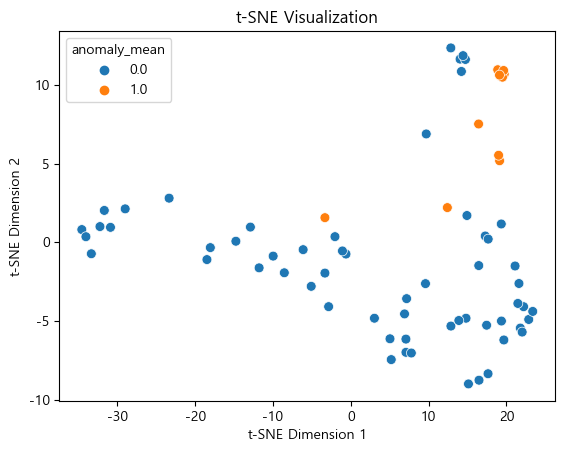

In [538]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE를 위한 객체 생성
tsne = TSNE(n_components=2, random_state=42)

data_tsne = tsne.fit_transform(tmp_sne)  # data는 변환할 데이터입니다.
data_tsne = pd.DataFrame(data_tsne)

i_train_tsne = data_tsne[data_tsne.index.isin(i_tr)]
i_train_tsne = np.array(i_train_tsne)

i_test_tsne = data_tsne[data_tsne.index.isin(i_te)]
i_test_tsne = np.array(i_test_tsne)

i_outliers_tsne = data_tsne[data_tsne.index.isin(i_outliers)]
i_outliers_tsne = np.array(i_outliers_tsne)

i_concat_tsne = data_tsne[data_tsne.index.isin(i_concat)]
i_concat_tsne = np.array(i_concat_tsne)

data_tsne = np.array(data_tsne)

# 변환된 데이터를 시각화
sns.scatterplot(data=i_concat_tsne, x=i_concat_tsne[:, 0],y=i_concat_tsne[:, 1],hue=i_y_concat, legend='brief', s=50, linewidth=0.5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()

In [547]:
from sklearn.ensemble import IsolationForest

# ▶ Model 학습 및 예측
# - n_estimators : 나무의 개수 (※ default 100)
# - max_samples : 서브샘플링 데이터 개수 (※ 정수는 개수, 실수(0~1)는 백분율, 전체 데이터 개수 or 256 중 작은 수)
# - contamination : 전체 데이터에서 이상치의 비율, 이 비율에 따라 이상치로 판단하기 위한 score의 threshold를 정의
# - max_features : 학습 시 사용할 Feature (※ default 1, 모두 사용)

clf = IsolationForest(contamination=0.06) #contamination을 0.1, 0.05, 0.03
clf.fit(i_train_tsne)
i_pred_train = clf.predict(i_train_tsne)
i_pred_test = clf.predict(i_test_tsne)
i_pred_outliers = clf.predict(i_outliers_tsne)
i_pred_concat = clf.predict(i_concat_tsne)
# y_pred_outliers = clf.predict(X_outliers)

In [548]:
I_label = i_pred_concat<0

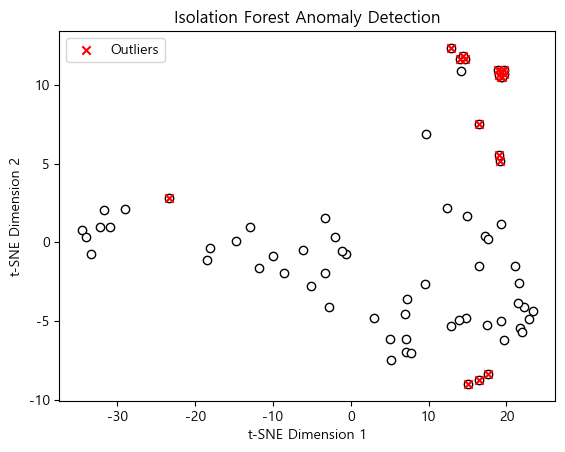

In [549]:
plt.scatter(i_concat_tsne[:, 0], i_concat_tsne[:, 1], c='white', edgecolors='k')
plt.scatter(i_concat_tsne[I_label, 0], i_concat_tsne[I_label, 1], c='red', edgecolors='k', marker='x', label='Outliers')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Isolation Forest Anomaly Detection')
plt.legend()
plt.show()

In [550]:
# ▶ 정상 data set을 얼만큼 정상으로 예측하였는지?
print("테스트 데이터셋에서 정확도:", list(i_pred_test).count(1)/i_pred_test.shape[0])

# ▶ Outlier data set을 얼마나 Outlier로 예측하였는지?
print("이상치 데이터셋에서 정확도:", list(i_pred_outliers).count(-1)/i_pred_outliers.shape[0])

테스트 데이터셋에서 정확도: 0.864406779661017
이상치 데이터셋에서 정확도: 0.8333333333333334


In [551]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# 혼동 행렬 계산 및 출력
confusion = confusion_matrix(i_y_concat, I_label)
print("Confusion Matrix:")
print(confusion)

# 분류 보고서 출력
report = classification_report(i_y_concat, I_label)
print("Classification Report:")
print(report)

Confusion Matrix:
[[51  8]
 [ 2 10]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91        59
         1.0       0.56      0.83      0.67        12

    accuracy                           0.86        71
   macro avg       0.76      0.85      0.79        71
weighted avg       0.89      0.86      0.87        71



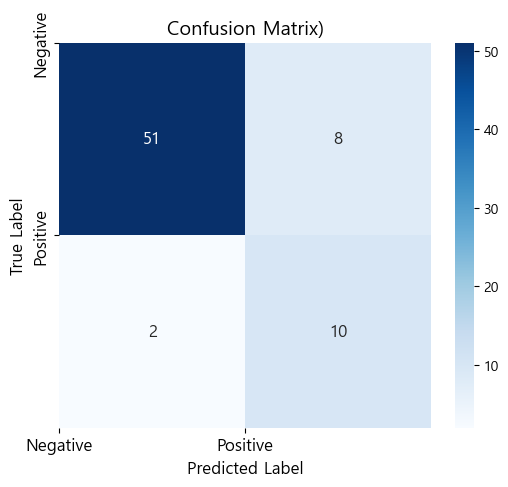

In [552]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


# 컨퓨전 매트릭스 생성
conf_matrix = confusion_matrix(i_y_concat,I_label)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})

plt.title(f"Confusion Matrix)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], fontsize=12)
plt.yticks(ticks=[0, 1], labels=["Negative", "Positive"], fontsize=12)
plt.show()

## OC-SVM

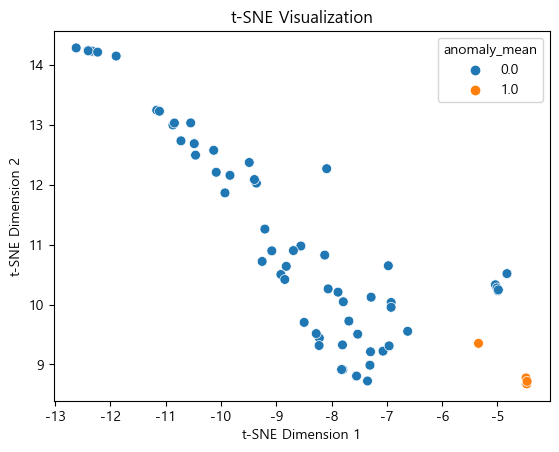

In [553]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE를 위한 객체 생성
tsne = TSNE(n_components=2, random_state=42)

# t-SNE를 통해 데이터를 2D 공간으로 변환
data_tsne = tsne.fit_transform(tmp_sne)  # data는 변환할 데이터입니다.
train_tsne = tsne.fit_transform(k_X_train)
test_tsne = tsne.fit_transform(k_X_test)

# 변환된 데이터를 시각화
sns.scatterplot(data=test_tsne, x=test_tsne[:, 0],y=test_tsne[:, 1],hue=k_y_test, legend='brief', s=50, linewidth=0.5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()

In [578]:
from sklearn import svm
#0.6, 0.05
clf = svm.OneClassSVM(nu=0.3, kernel="linear", gamma=0.1)
clf.fit(train_tsne)
O_pred_train = clf.predict(test_tsne)
O_label = O_pred_train < 0

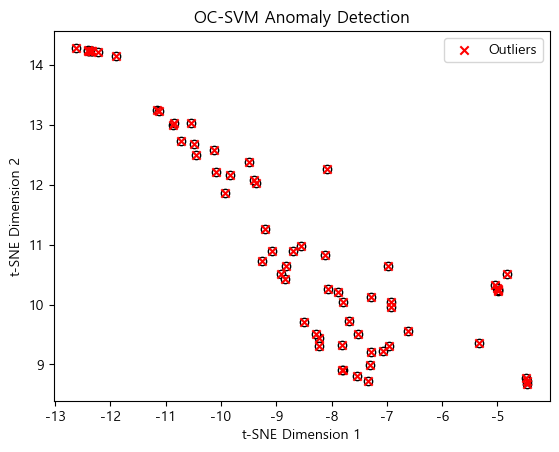

In [579]:
plt.scatter(test_tsne[:, 0], test_tsne[:, 1], c='white', edgecolors='k')
plt.scatter(test_tsne[O_label, 0], test_tsne[O_label, 1], c='red', edgecolors='k', marker='x', label='Outliers')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('OC-SVM Anomaly Detection')
plt.legend()
plt.show()

In [383]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# 혼동 행렬 계산 및 출력
confusion = confusion_matrix(k_y_test, O_label)
print("Confusion Matrix:")
print(confusion)

# 분류 보고서 출력
report = classification_report(k_y_test, O_label)
print("Classification Report:")
print(report)

Confusion Matrix:
[[63  0]
 [ 1  3]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        63
         1.0       1.00      0.75      0.86         4

    accuracy                           0.99        67
   macro avg       0.99      0.88      0.92        67
weighted avg       0.99      0.99      0.98        67



## LOF

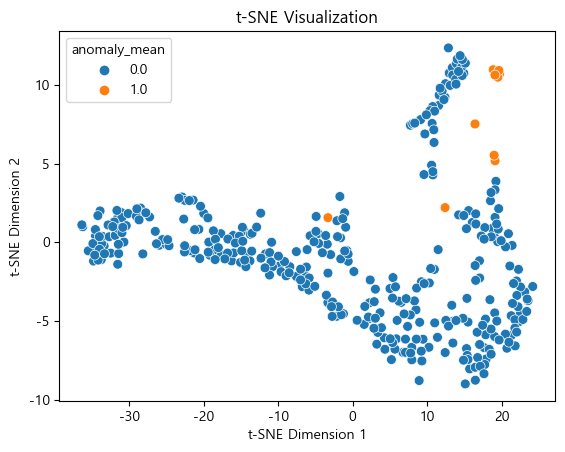

In [580]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE를 위한 객체 생성
tsne = TSNE(n_components=2, random_state=42)

# t-SNE를 통해 데이터를 2D 공간으로 변환
data_tsne = tsne.fit_transform(tmp_sne)  # data는 변환할 데이터입니다.
train_tsne = tsne.fit_transform(k_X_train)
test_tsne = tsne.fit_transform(k_X_test)

# 변환된 데이터를 시각화
sns.scatterplot(data=data_tsne, x=data_tsne[:, 0],y=data_tsne[:, 1],hue=tmp['anomaly_mean'], legend='brief', s=50, linewidth=0.5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()

In [581]:
from sklearn.neighbors import LocalOutlierFactor
# ▶ 모델 생성 및 예측, n_neighbors, contamination을 변경해보세요. 제일 먼저는 default 값으로 설정해보고 상황에 맞춰 변경해보기 바랍니다.
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.04)
lof_predict = lof.fit_predict(data_tsne)
lof_label = lof_predict<0

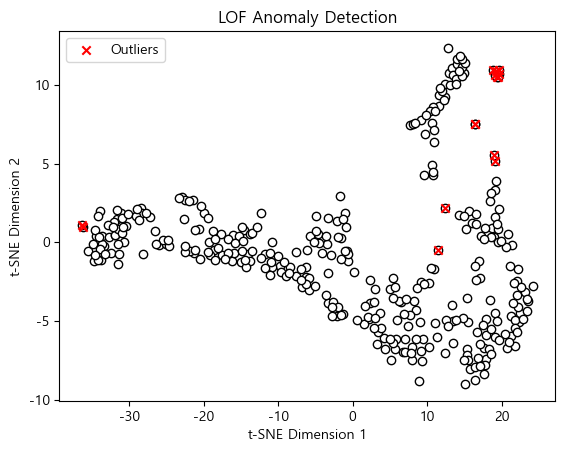

In [582]:
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c='white', edgecolors='k')
plt.scatter(data_tsne[lof_label, 0], data_tsne[lof_label, 1], c='red', edgecolors='k', marker='x', label='Outliers')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('LOF Anomaly Detection')
plt.legend()
plt.show()

In [327]:
# ▶ LOF 값 확인
# ▶ negative_outlier_factor_ : The opposite LOF of the training samples. LOF 값이 음수로 나옴.
lof.negative_outlier_factor_

array([-1.3377917 , -1.0867202 , -0.98412055, -1.1672056 , -1.0127532 ,
       -0.9854994 , -1.0011753 , -0.9591702 , -1.0925635 , -1.0217483 ,
       -0.9704267 , -0.99522245, -1.0327022 , -1.0764034 , -0.9795345 ,
       -1.1061398 , -0.99567735, -1.0595099 , -0.9799687 , -0.99540013,
       -1.0129592 , -1.1880256 , -1.0475479 , -1.0930172 , -1.050658  ,
       -1.1984594 , -1.175411  , -1.1389341 , -0.97512066, -1.0780379 ,
       -0.99233407, -0.97732055, -1.0279295 , -1.0213926 , -0.9532714 ,
       -1.0112197 , -1.0223238 , -1.0122844 , -0.9894579 , -0.9965889 ,
       -1.088366  , -1.0258813 , -1.0673842 , -1.0153744 , -0.996435  ,
       -0.96217555, -1.0175112 , -0.963346  , -1.2259252 , -0.99831915,
       -1.0107852 , -1.0174949 , -1.0376688 , -1.0451932 , -0.9700125 ,
       -1.0921518 , -1.0905926 , -1.021869  , -0.9783738 , -1.1450808 ,
       -0.9730834 , -1.0007142 , -0.96478903, -1.0107268 , -1.0693175 ,
       -1.025112  , -0.9840558 , -0.99022424, -1.0023713 , -1.02

In [583]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# 혼동 행렬 계산 및 출력
confusion = confusion_matrix(tmp['anomaly_mean'], lof_label)
print("Confusion Matrix:")
print(confusion)

# 분류 보고서 출력
report = classification_report(tmp['anomaly_mean'], lof_label)
print("Classification Report:")
print(report)

Confusion Matrix:
[[348   4]
 [  1  11]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       352
         1.0       0.73      0.92      0.81        12

    accuracy                           0.99       364
   macro avg       0.87      0.95      0.90       364
weighted avg       0.99      0.99      0.99       364



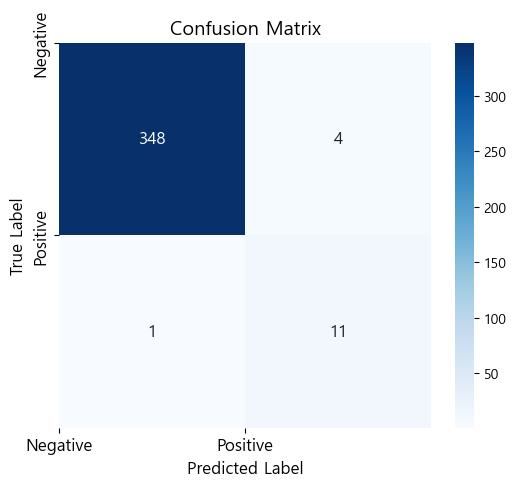

In [584]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


# 컨퓨전 매트릭스 생성
conf_matrix = confusion_matrix(tmp['anomaly_mean'], lof_label)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})

plt.title(f"Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], fontsize=12)
plt.yticks(ticks=[0, 1], labels=["Negative", "Positive"], fontsize=12)
plt.show()

## AutoEncoder

In [ ]:
i_X_train = tmp[tmp.index.isin(i_tr)].drop('anomaly_mean', axis=1)
i_y_train = tmp[tmp.index.isin(i_tr)]['anomaly_mean']

i_X_concat = tmp[tmp.index.isin(i_concat)].drop('anomaly_mean', axis=1)
i_y_concat = tmp[tmp.index.isin(i_concat)]['anomaly_mean']

i_X_outliers = tmp[tmp.index.isin(i_outliers)].drop('anomaly_mean', axis=1)
i_y_outliers = tmp[tmp.index.isin(i_outliers)]['anomaly_mean']

i_tr 
i_te
i_outliers

In [488]:
ae_train = tmp1[tmp1.index.isin([0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 257, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278,
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 292,
       293, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 341, 342, 343, 344, 345, 346, 347,
       348, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 361, 362,
       363])]
ae_test = tmp1[tmp1.index.isin(i_outliers)]

ae_train.shape

(352, 11)

In [515]:
i_train_tsne
i_outliers_tsne

array([[-3.3880758,  1.8058555],
       [12.64029  ,  2.2828963],
       [20.382301 , 10.412311 ],
       [19.991184 , 10.25804  ],
       [16.877352 ,  7.3960624],
       [19.982197 , 10.634979 ],
       [19.497732 ,  5.015175 ],
       [20.14999  , 10.220246 ],
       [19.54411  , 10.719364 ],
       [20.30889  , 10.65004  ],
       [19.379646 ,  5.3683424],
       [19.76902  , 10.36599  ]], dtype=float32)

In [489]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential

n_features = 11
latent_dim = 2

enc_inputs = layers.Input(shape = (n_features,)) #300
x = layers.Dense(128, activation = 'relu')(enc_inputs)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(16, activation = 'relu')(x)
x = layers.Dense(8, activation = 'relu')(x)
x = layers.Dense(4, activation = 'relu')(x)
x = layers.Dense(2, activation = 'relu')(x)
enc_outputs = layers.Dense(latent_dim, activation= 'relu')(x) #latent vector(100)
encoder = Model(inputs = enc_inputs, outputs = enc_outputs)


dnc_inputs = layers.Input(shape = (latent_dim,)) #latent vector(100)
x = layers.Dense(2, activation = 'relu')(dnc_inputs)
x = layers.Dense(4, activation = 'relu')(x)
x = layers.Dense(8, activation = 'relu')(x)
x = layers.Dense(16, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dense(128, activation = 'relu')(x)


dnc_outputs = layers.Dense(n_features, activation = 'linear')(x) #300
decoder = Model(inputs = dnc_inputs, outputs = dnc_outputs)
#오토인코더

inputs = layers.Input(shape=(n_features))
latent = encoder(inputs)
outputs = decoder(latent)

AE = Model(inputs = inputs, outputs=outputs)
AE.compile(optimizer='adam', loss='mse')
AE.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 11)]              0         
                                                                 
 model_36 (Functional)       (None, 2)                 49772     
                                                                 
 model_37 (Functional)       (None, 11)                49781     
                                                                 
Total params: 99,553
Trainable params: 99,553
Non-trainable params: 0
_________________________________________________________________


In [509]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
AE.fit(ae_train, ae_train, validation_split=0.2, batch_size=256, epochs=350, callbacks=[early_stopping])

Epoch 1/350
2/2 [==============================] - 0s 61ms/step - loss: 14000.5527 - val_loss: 15434.8926
Epoch 2/350
2/2 [==============================] - 0s 41ms/step - loss: 14049.7168 - val_loss: 15442.5674
Epoch 3/350
2/2 [==============================] - 0s 33ms/step - loss: 14029.2178 - val_loss: 15466.3818
Epoch 4/350
2/2 [==============================] - 0s 24ms/step - loss: 13997.1943 - val_loss: 15526.5527
Epoch 5/350
2/2 [==============================] - 0s 23ms/step - loss: 13944.8965 - val_loss: 15554.2480
Epoch 6/350
2/2 [==============================] - 0s 19ms/step - loss: 13927.0732 - val_loss: 15540.0420
Epoch 7/350
2/2 [==============================] - 0s 14ms/step - loss: 13933.4678 - val_loss: 15466.5830
Epoch 8/350
2/2 [==============================] - 0s 37ms/step - loss: 13987.6963 - val_loss: 15410.8613
Epoch 9/350
2/2 [==============================] - 0s 38ms/step - loss: 14225.9854 - val_loss: 15407.3643
Epoch 10/350
2/2 [============================

In [510]:
p_normal_test = AE.predict(ae_train)
p_anormal_test = AE.predict(ae_test)

1/1 [==============================] - 0s 14ms/step


In [511]:
def reconstruction_error(x,p):
    return np.mean(np.abs(x - p), axis = 1)

re_normal = reconstruction_error(ae_train, p_normal_test)
re_anormal = reconstruction_error(ae_test, p_anormal_test)

p_anormal_test.shape

(12, 11)

In [512]:
re_all = np.concatenate([re_normal, re_anormal])
label_all = np.concatenate([np.zeros_like(re_normal),
                            np.ones_like(re_anormal)])

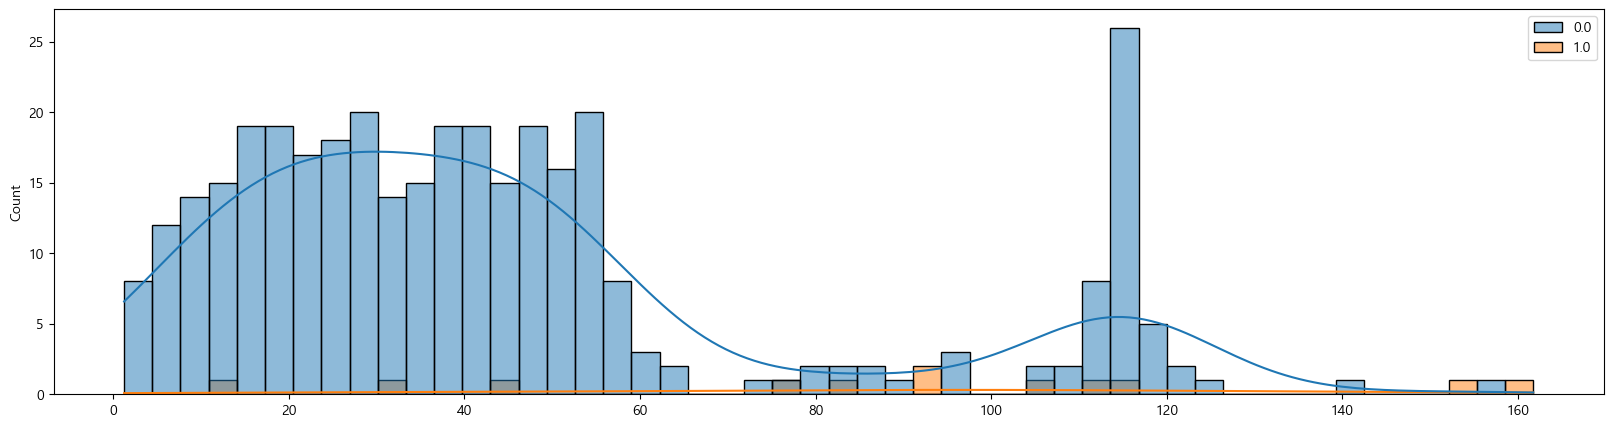

In [513]:
plt.figure(figsize=(20,5))
sns.histplot(x=re_all, bins=50, hue=label_all, kde=True)
plt.show()

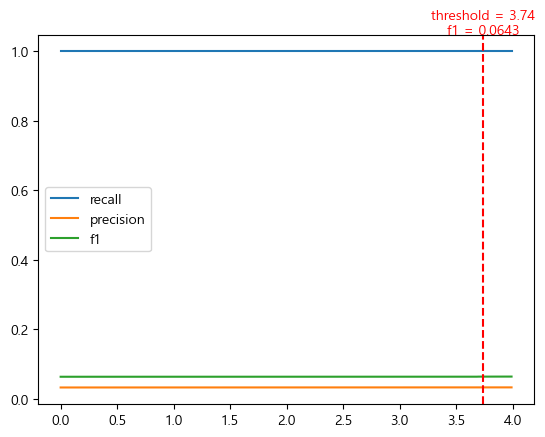

In [498]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve

recall = []
precision = []
f1 = []

thresholds = np.arange(0, 4, 0.01)
for thres in thresholds:
    results = re_all > thres
    recall.append(recall_score(label_all, results))
    precision.append(precision_score(label_all, results))
    f1.append(f1_score(label_all, results))

plt.figure()
plt.plot(thresholds, recall, label='recall')
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, f1, label='f1')

plt.axvline(thresholds[np.argmax(f1)], color='red', linestyle='--')
plt.text(thresholds[np.argmax(f1)], 1.05, 'threshold = {}\nf1 = {:.4f}'.format(thresholds[np.argmax(f1)], np.max(f1)),
         color='red', horizontalalignment='center')

plt.legend()
plt.show()

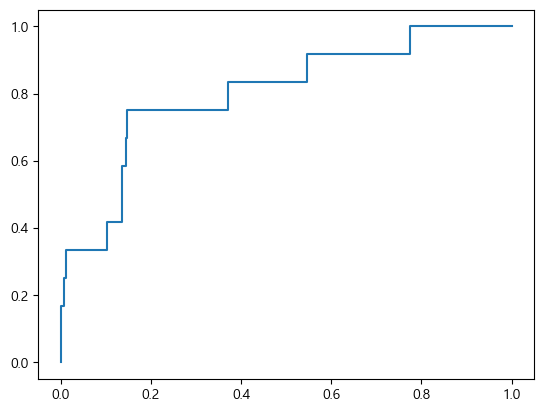

In [499]:
fpr, tpr, _ = roc_curve(label_all, re_all)
plt.plot(fpr,tpr)
plt.show()

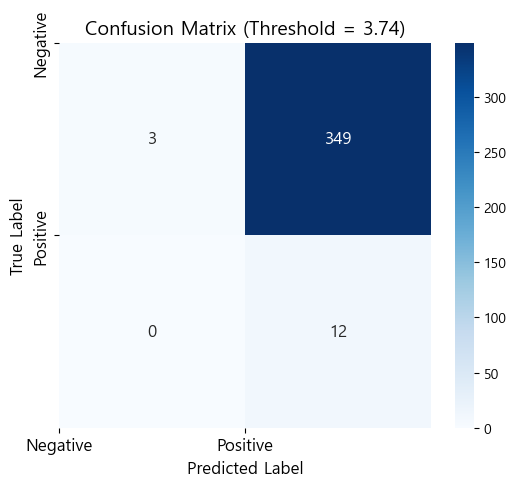

In [502]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# 임계값(threshold) 설정 (0부터 1 사이의 값을 지정)
threshold = 3.74

# 예측 결과 계산
predicted_results = re_all > threshold

# 컨퓨전 매트릭스 생성
conf_matrix = confusion_matrix(label_all, predicted_results)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})

plt.title(f"Confusion Matrix (Threshold = {threshold})", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], fontsize=12)
plt.yticks(ticks=[0, 1], labels=["Negative", "Positive"], fontsize=12)
plt.show()

In [503]:
from sklearn.metrics import classification_report

conf_matrix = confusion_matrix(label_all, predicted_results)

# Confusion Matrix 출력
print("Confusion Matrix:")
print(conf_matrix)

# 분류 보고서 출력
target_names = ['정상치', '이상치']
print("\nClassification Report:")
print(classification_report(label_all, predicted_results, target_names=target_names))


Confusion Matrix:
[[  3 349]
 [  0  12]]

Classification Report:
              precision    recall  f1-score   support

         정상치       1.00      0.01      0.02       352
         이상치       0.03      1.00      0.06        12

    accuracy                           0.04       364
   macro avg       0.52      0.50      0.04       364
weighted avg       0.97      0.04      0.02       364

